In [221]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [222]:
import numpy as np
import pandas as pd

In [223]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [224]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [225]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [226]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [227]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [228]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [229]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Max Date: 2017-08-23
Last year Date: 2016-08-23


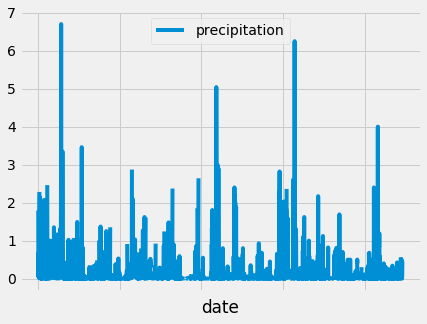

In [418]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from today
#Get the max fate in the table
def str_date(sdate):
    return dt.datetime.strptime(sdate, "%Y-%m-%d").date()

maxdatequery = session.query(func.max(Measurement.date)).first()[0]
maxdate = str_date(maxdatequery)
print("Max Date: " + str(maxdate))
#Get the last year date
lastyear = maxdate - dt.timedelta(days=365)
print("Last year Date: " + str(lastyear))
# Perform a query to retrieve the data and precipitation scores
sql = session.query(Measurement.date, Measurement.prcp.label("precipitation")).filter(Measurement.date >= lastyear).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
results = pd.DataFrame(sql, columns=["date","precipitation"])
results.set_index("date", inplace=True)
# Sort the dataframe by date
results.sort_index(ascending=True, inplace=True)

######################################################
#Solution pandas executing the query, for me is cleaner 
#sql_statement = session.query(Measurement.date, Measurement.prcp.label("precipitation")).filter(Measurement.date >= lastyear).order_by(Measurement.date).statement
#results = pd.read_sql_query(sql_statement, session.bind, index_col="date")
######################################################

# Use Pandas Plotting with Matplotlib to plot the data
# Rotate the xticks for the dates
plt.rcParams["figure.figsize"] = [6.4, 4.8]
results.plot(x_compat=True)
plt.show()

In [419]:
# Use Pandas to calcualte the summary statistics for the precipitation data
results.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [420]:
# How many stations are available in this dataset?
session.query(func.count(func.distinct(Measurement.station))).first()

(9)

In [421]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.id).label("total")).group_by(Measurement.station).order_by(desc("total")).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [422]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281").first()

(54.0, 85.0, 71.66378066378067)

Station with highest number of temperature: USC00511918
Max Date: 2015-10-30
Last year Date: 2014-10-30


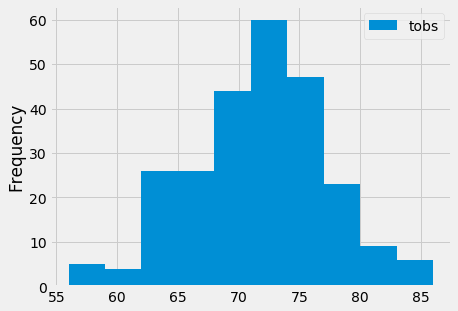

In [424]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#print(session.query(Measurement.station, func.max(Measurement.tobs).label("max_temp")).group_by(Measurement.station).order_by(desc("max_temp")).all())
maxstation_sql = session.query(Measurement.station, func.max(Measurement.tobs).label("max_temp")).group_by(Measurement.station).order_by(desc("max_temp")).first()
maxstation = maxstation_sql[0]
print("Station with highest number of temperature: " + maxstation)
maxdatequery2 = session.query(func.max(Measurement.date)).filter(Measurement.station == maxstation).first()[0]
maxdate2 = str_date(maxdatequery2)
print("Max Date: " + str(maxdate2))
lastyear2 = maxdate2 - dt.timedelta(days=365)
print("Last year Date: " + str(lastyear2))
maxstation12m_sql = session.query(Measurement.tobs).filter(Measurement.date >= lastyear2).filter(Measurement.station == maxstation).all()
plt.rcParams["figure.figsize"] = [6.4, 4.8]
pd.DataFrame(maxstation12m_sql).plot.hist()
plt.show()

In [425]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    print(session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date))
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

print(calc_temps('2012-02-28', '2012-03-05'))

SELECT min(measurement.tobs) AS min_1, avg(measurement.tobs) AS avg_1, max(measurement.tobs) AS max_1 
FROM measurement 
WHERE measurement.date >= ? AND measurement.date <= ?
[(62.0, 69.57142857142857, 74.0)]


In [426]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print("Max Date: " + str(maxdate))
print("Last year Date: " + str(lastyear))
results3 = calc_temps(lastyear, maxdate)
print(results3)

Max Date: 2017-08-23
Last year Date: 2016-08-23
SELECT min(measurement.tobs) AS min_1, avg(measurement.tobs) AS avg_1, max(measurement.tobs) AS max_1 
FROM measurement 
WHERE measurement.date >= ? AND measurement.date <= ?
[(58.0, 74.59058295964125, 87.0)]


avg_temp: 74.59058295964125
yerrcalc: -29.0


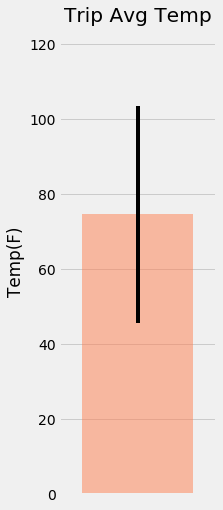

In [428]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
avg_temp = results3[0][1]
max_temp = results3[0][0]
min_temp = results3[0][2]
yerrcalc = max_temp-min_temp
print("avg_temp: " + str(avg_temp))
print("yerrcalc: " + str(yerrcalc))
plt.title("Trip Avg Temp")
plt.bar(np.arange(1), avg_temp, color="coral", yerr=yerrcalc, alpha=0.5)
plt.margins(0.2, 0.2)
plt.xticks([])
plt.ylabel("Temp(F)")
plt.rcParams["figure.figsize"] = [2.5,8]
plt.show()

In [430]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
print("Last year date: " + str(lastyear))
sql_station_rain = session.query(Measurement.station, func.sum(Measurement.prcp).label("precipitation_amount")).\
    filter(Measurement.date >= lastyear).group_by(Measurement.station).order_by(desc("precipitation_amount")).statement
stations_rain = pd.read_sql_query(sql_station_rain, session.bind)

stations = pd.read_sql_query(session.query(Station).statement, session.bind)

stations_rain_final = pd.merge(stations_rain, stations, on="station", how="inner")
stations_rain_final[["station","name","latitude","longitude", "elevation", "precipitation_amount"]]

Last year date: 2016-08-23


,station,name,latitude,longitude,elevation,precipitation_amount
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,147.81
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,70.03
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,48.51
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,38.01
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,33.24
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,16.09
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,4.59


## Optional Challenge Assignment

In [431]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [433]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
# Set the start and end date of the trip
start_date = str_date("2018-01-01")
end_date = str_date("2018-01-08")

# Use the start and end date to create a range of dates
date_range = [start_date + dt.timedelta(days=x) for x in range(0, (end_date-start_date).days)]

# Stip off the year and save a list of %m-%d strings
date_range_normals = [dt.date.strftime(x, "%m-%d") for x in date_range]
# Loop through the list of %m-%d strings and calculate the normals for each date
[normals.append(daily_normals(x)[0]) for x in date_range_normals]
normals

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [434]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_result = pd.DataFrame(normals, columns=["tmin","tavg","tmax"])
trip_result["date"] = date_range
trip_result.set_index("date", inplace=True)
trip_result.head()

,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


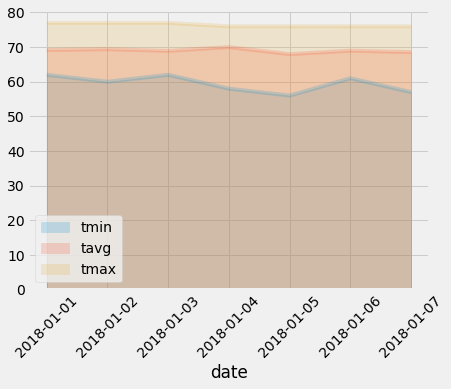

In [436]:
# Plot the daily normals as an area plot with `stacked=False`
trip_result.plot.area(alpha=0.2, stacked=False)
plt.xticks(rotation=45)
plt.show()
plt.rcParams["figure.figsize"] = [6.4, 4.8]